### Build and test a Naive Bayes classifier.

We will again use the iris data. 

Goals for this notebook:
1. Understand NB well enough to make a prediction by hand
2. Use the naive_bayes module in scikit-learn
3. First glimpse at the pandas package for manipulating data

In [75]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
import math as math

In [2]:
# Load the data, which is included in sklearn.
iris = load_iris()
print 'Iris target names:', iris.target_names
print 'Iris feature names:', iris.feature_names
X, y = iris.data, iris.target

Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [3]:
X[:10]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 5. ,  3.4,  1.5,  0.2],
       [ 4.4,  2.9,  1.4,  0.2],
       [ 4.9,  3.1,  1.5,  0.1]])

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [9]:
X_train[:10]

array([[ 5.9,  3. ,  4.2,  1.5],
       [ 5.8,  2.6,  4. ,  1.2],
       [ 6.8,  3. ,  5.5,  2.1],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 6.9,  3.1,  5.1,  2.3],
       [ 5. ,  3.5,  1.6,  0.6],
       [ 5.4,  3.7,  1.5,  0.2],
       [ 5. ,  2. ,  3.5,  1. ],
       [ 6.5,  3. ,  5.5,  1.8],
       [ 6.7,  3.3,  5.7,  2.5]])

In [7]:
X_test.shape

(38, 4)

## EDA

The iris feature values are real valued measurements in centimeters. Let's look at histograms of each feature.

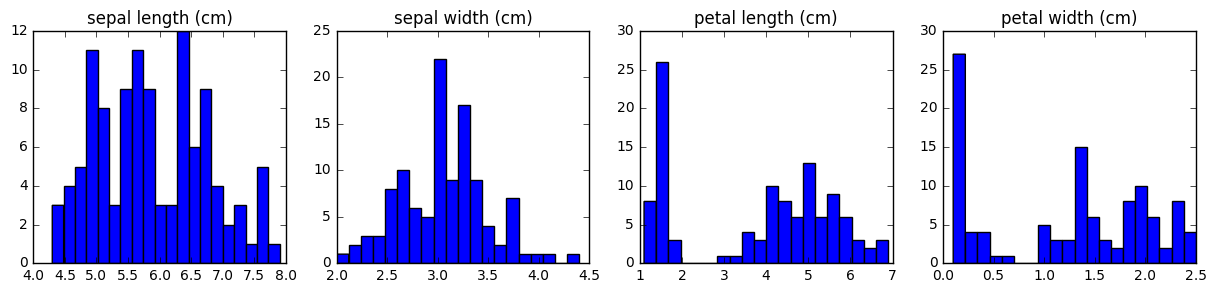

In [8]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 4 features.
plt.figure(figsize=(15, 3))

# Iterate over the features, creating a subplot with a histogram for each one.
for feature in range(X_train.shape[1]):
    plt.subplot(1, 4, feature+1)
    plt.hist(X_train[:,feature], 20)
    plt.title(iris.feature_names[feature])

To make things simple, let's binarize these feature values. That is, we'll treat each measurement as either "short" or "long". I'm just going to choose a threshold for each feature.

In [10]:
# Define a function that applies a threshold to turn real valued iris features into 0/1 features.
# 0 will mean "short" and 1 will mean "long".
#Can mess around with these thresholds to see how they impact predictions
def binarize_iris(data, thresholds=[6.0, 3.0, 2.5, 1.0]):
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.zeros(data.shape)

    # Apply a threshold  to each feature.
    for feature in range(data.shape[1]):
        binarized_data[:,feature] = data[:,feature] > thresholds[feature]
    return binarized_data

# Create new binarized training and test data
binarized_train_data = binarize_iris(X_train)
binarized_test_data = binarize_iris(X_test)

print X_train[:10, ]
print binarized_train_data[:10, ]

[[ 5.9  3.   4.2  1.5]
 [ 5.8  2.6  4.   1.2]
 [ 6.8  3.   5.5  2.1]
 [ 4.7  3.2  1.3  0.2]
 [ 6.9  3.1  5.1  2.3]
 [ 5.   3.5  1.6  0.6]
 [ 5.4  3.7  1.5  0.2]
 [ 5.   2.   3.5  1. ]
 [ 6.5  3.   5.5  1.8]
 [ 6.7  3.3  5.7  2.5]]
[[ 0.  0.  1.  1.]
 [ 0.  0.  1.  1.]
 [ 1.  0.  1.  1.]
 [ 0.  1.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 0.  1.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  1.  1.]
 [ 1.  1.  1.  1.]]


Recall that Naive Bayes assumes conditional independence of features. With $Y$ the set of labels and $X$ the set of features ($y$ is a specific label and $x$ is a specific feature), Naive Bayes gives the probability of a label $y$ given input features $X$ as:

$ \displaystyle P(y|X) \approx 
  \frac { P(y) \prod_{x \in X} P(x|y) }
        { \sum_{y \in Y} P(y) \prod_{x \in X} P(x|y) }
$

Let's estimate some of these probabilities using maximum likelihood, which is just a matter of counting and normalizing. We'll start with the prior probability of the label $P(y)$.

In [11]:
# Initialize counters for all labels to zero.
label_counts = [0 for i in iris.target_names]

# Iterate over labels in the training data and update counts.
for label in y_train:
    label_counts[label] += 1

# Normalize counts to get a probability distribution.
total = sum(label_counts)
label_probs = [1.0 * count / total for count in label_counts]
for (prob, name) in zip(label_probs, iris.target_names):
    print '%15s : %.2f' %(name, prob)

         setosa : 0.33
     versicolor : 0.30
      virginica : 0.37


### Repeat above three cells using pandas

Pandas allows us to stop thinking about code in terms of procedures, and start thinking about code in terms of _data manipulation_.

- Check out pandas here: pandas.pydata.org
- [Here](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf) is cheat sheet to get a sense for what is possible.
- [This](http://pandas.pydata.org/pandas-docs/stable/10min.html) is probably the best place to get started


Load the training data into a pandas data frame

In [45]:
iris.feature_names
colnames = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [46]:
df = pd.DataFrame(X, columns = names)
df.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [19]:
#Can reference columns by name
df.sepal_length

0      5.1
1      4.9
2      4.7
3      4.6
4      5.0
5      5.4
6      4.6
7      5.0
8      4.4
9      4.9
10     5.4
11     4.8
12     4.8
13     4.3
14     5.8
15     5.7
16     5.4
17     5.1
18     5.7
19     5.1
20     5.4
21     5.1
22     4.6
23     5.1
24     4.8
25     5.0
26     5.0
27     5.2
28     5.2
29     4.7
      ... 
120    6.9
121    5.6
122    7.7
123    6.3
124    6.7
125    7.2
126    6.2
127    6.1
128    6.4
129    7.2
130    7.4
131    7.9
132    6.4
133    6.3
134    6.1
135    7.7
136    6.3
137    6.4
138    6.0
139    6.9
140    6.7
141    6.9
142    5.8
143    6.8
144    6.7
145    6.7
146    6.3
147    6.5
148    6.2
149    5.9
Name: sepal_length, dtype: float64

Can describe the data frame

In [20]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [22]:
#convert labels to series
labels = pd.Series(y)
labels.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [25]:
#Add a new column with the labels / targets
df['target'] = labels

df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


In [29]:
#Replace the numerical targes with their names
df = df.replace({'target':{0:'Setosa', 1:'Versicolor', 2:'Virginica'}})
df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


Redo the train/test split

In [30]:
train_df, test_df = train_test_split(df, random_state = 0)

In [32]:
train_df.shape

(112, 5)

Plot some histograms

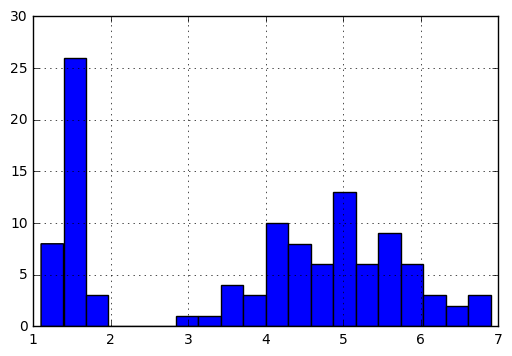

In [34]:
train_df['petal_length'].hist(bins = 20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117257350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116e32e10>]], dtype=object)

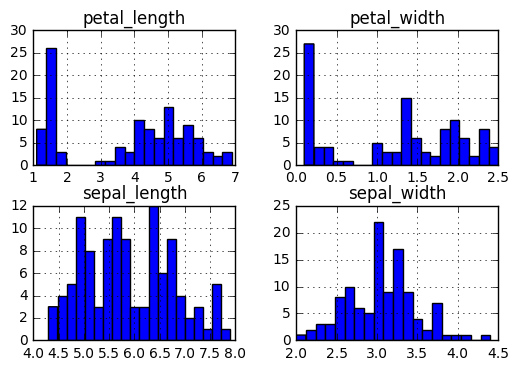

In [35]:
#calling hist on th entire data frame plots a histogram for all columns
train_df.hist(bins = 20)

Binarize the columns

In [41]:
#Thresholds

thresholds = np.array([6.0, 3.0, 2.5, 1.0])

#binarizing data is a row by row operation.
#look at each entry in the data frame.
test_row = np.array([5.5, 3.5, 2, 1.5])

#converting to numpy array, numpy knows to vectorize this operation
test_row > thresholds



array([False,  True, False,  True], dtype=bool)

In [52]:
#binarize using apply
#index by the list colnames so that the function is only applied to the first four columns containing features
train_df_binarized = train_df[colnames].apply(lambda row: row > thresholds, axis = 1)
test_df_binarized = test_df[colnames].apply(lambda row: row > thresholds, axis = 1)

train_df_binarized.head()
test_df_binarized.head()

,sepal_length,sepal_width,petal_length,petal_width
114,False,False,True,True
62,False,False,True,False
33,False,True,False,False
107,True,False,True,True
7,False,True,False,False


In [54]:
train_df_binarized.shape
test_df_binarized.shape

(38, 4)

Estimate priors

In [37]:
#get counts of each category
#normalize option gives the probabilities instead of counts

train_df['target'].value_counts(normalize = True)

Virginica     0.366071
Setosa        0.330357
Versicolor    0.303571
Name: target, dtype: float64

## Naive Bayes by Hand

Next, let's estimate $P(X|Y)$, that is, the probability of each feature given each label. Remember that we can get the conditional probability from the joint distribution:

$\displaystyle P(X|Y) = \frac{ P(X,Y) } { P(Y) } \approx \frac{ \textrm{Count}(X,Y) } { \textrm{Count}(Y) }$

Let's think carefully about the size of the count matrix we need to collect. There are 3 labels $y_1$, $y_2$, and $y_3$ and 4 features $x_0$, $x_1$, $x_2$, and $x_3$. Each feature has 2 possible values, 0 or 1. So there are actually $4 \times 2 \times 3=24$ probabilities we need to estimate: 

$P(x_0=0, Y=y_0)$

$P(x_0=1, Y=y_0)$

$P(x_1=0, Y=y_0)$

$P(x_1=1, Y=y_0)$

...

However, we already estimated (above) the probability of each label. And, we know that each feature value is either 0 or 1. So, for example,

$P(x_0=0, Y=\textrm{setosa}) + P(x_0=1, Y=\textrm{setosa}) = P(Y=\textrm{setosa}) \approx 0.31$.

As a result, we can just estimate probabilities for one of the feature values, say, $x_i = 1$. This requires a $4 \times 3$ matrix.




Append target to binarized data

In [55]:
train_df_binarized['target'] = train_df['target']

train_df_binarized.head()

,sepal_length,sepal_width,petal_length,petal_width,target
61,False,False,True,True,Versicolor
92,False,False,True,True,Versicolor
112,True,False,True,True,Virginica
2,False,True,False,False,Setosa
141,True,True,True,True,Virginica


Conditional probabilities of feature_i > thresh

In [60]:
#calculate average by group
conditional_probs = train_df_binarized.groupby('target').mean()

conditional_probs

,sepal_length,sepal_width,petal_length,petal_width
target,,,,
Setosa,0.000000,0.837838,0.0,0.000000
Versicolor,0.352941,0.176471,1.0,0.852941
Virginica,0.829268,0.365854,1.0,1.000000


In [62]:
#Can access these conditional probabilities by name
conditional_probs.loc['Versicolor', 'sepal_length']



0.35294117647058826

Priors

In [63]:
priors = train_df_binarized['target'].value_counts(normalize = True)

priors


Virginica     0.366071
Setosa        0.330357
Versicolor    0.303571
Name: target, dtype: float64

In [65]:
priors['Virginica']

0.36607142857142855

Now that we have all the pieces, let's try making a prediction for the first test example. 

In [68]:
test_instance = test_df.iloc[0]
test_instance

sepal_length          5.8
sepal_width           2.8
petal_length          5.1
petal_width           2.4
target          Virginica
Name: 114, dtype: object

In [69]:
test_instance_binarized = test_df_binarized.iloc[0]
test_instance_binarized

sepal_length    False
sepal_width     False
petal_length     True
petal_width      True
Name: 114, dtype: bool

#### Exercise

Compute the probability, according to the Naive Bayes model, that the label of this observation is 'virginica'

1: Write a function that takes a label as input and returns _the numerator_ of the NB equation. That is, P(y) * P(x | y)

Note: This function does not need to handle any possible input observation. It can be hard-coded to specifically handle `test_instance_binarized`.

Note: The funtion should actually return the _log_ of the numerator...

In [81]:
def lognum(label):
    
    """
    Compute P(label) * P(features | label)
    """
    
    prior = priors[label]
    #because sepal length is false, we take 1 - probability from conditional prob table
    p_sl = 1 - conditional_probs.loc[label, 'sepal_length']
    p_sw = 1 - conditional_probs.loc[label, 'sepal_width']
    #because petal length is true (i.e. above the threshold), we simply read the prob from the conditional probability table
    p_pl = conditional_probs.loc[label, 'petal_length']
    p_pw = conditional_probs.loc[label, 'petal_width']
    
    conditional = np.sum(np.log([p_sl, p_sw, p_pl, p_pw]))

    score = prior * conditional
    
    return score

Test

In [82]:
label = 'Virginica'
test = lognum(label)
test

-0.81382710088932686

2: Compute the log of the numberator for each possible label

In [80]:
np.log(test)

/Users/nwchen24/anaconda/envs/Machine_learning_python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


nan

3: Convert the results of (2) into probabilities

## Naive Bayes in Scikit-Learn

### BernoulliNB means _the features are distributed Bernoulli_

### GaussianNB _means the features are distributed Gaussian_

Exercise: Build a GaussianNB model using sklearn, and estimate the accuracy on the test set.

Let's look at those predicted probabilities

The predicted probabilities are _very_ confident. Since the test predictions are also extremely accurate, we might conclude that GaussianNB is an appropriate model

### MultinomialNB _means the features are distributed multinomial_

In [1]:
# Percentile cuts to use for discretizing data
cuts = [0, .2, ..66, 1]
breaks = train_df[colnames].quantile(cuts)
breaks.loc[0, :] = 0  # Set a global minimimum
breaks.loc[1, :] = 10  # Set a global maximum
print breaks

NameError: name 'train_df' is not defined

In [ ]:
# Discretize each column according to the breaks defined above
train_df_mult = train_df[colnames].apply(
    lambda col: pd.cut(col, bins=breaks[col.name], include_lowest=True, labels=False)
)
test_df_mult = test_df[colnames].apply(
    lambda col: pd.cut(col, bins=breaks[col.name], include_lowest=True, labels=False))

In [ ]:
train_df_mult.head()

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=1)
nb.fit(train_df_mult, train_df['target'])
nb.score(test_df_mult, test_df['target'])

## Bonus:

Consider the following threshold possibilities for each of the four features.

```
sepal_length_thresh = [5.0, 5.6, 6.2, 6.5]
sepal_width_thresh = [2.7, 3.0, 3.2, 3.4]
petal_length_thresh = [2, 3, 4, 5]
petal_width_thresh = [.5, 1, 1.5, 2]
```

Find the combination of thresholds (one from each list), that gives the BernoulliNB model with the highest accuracy.

Use a train/test/dev split, and report accuracy on the test set.